In [14]:
import pandas as pd

# Wczytanie danych
df = pd.read_csv('sport.csv')

# Wyświetlenie podstawowych informacji
print(df.head())
print(df.info())


   Unnamed: 0  sex        date  age  height  weight discipline  AeT  AnT  \
0           0    1  2023-07-21   45     184    81.0    running  128  157   
1           1    0  2023-08-04   33     171    64.0    running  171  184   
2           2    1  2023-08-04   38     185    72.0    running  157  178   
3           3    1  2023-08-04   37     182    81.0  triathlon  134  176   
4           4    1  2023-08-02   40     175    72.0    running  139  158   

   vo2max  ...  hr_10  la_10  hr_12  la_12  hr_14  la_14   z2   z3   z4   z5  
0    56.3  ...    133    3.2    138    3.3  149.0    3.5  121  129  149  158  
1    52.8  ...    168    5.2    180    1.6  186.0    1.8  154  172  178  185  
2    56.2  ...    128    1.2    140    1.0  152.0    1.2  138  158  167  179  
3    53.3  ...    127    1.9    143    2.3  162.0    2.6  123  135  162  177  
4    58.7  ...    132    1.0    145    3.2  158.0    5.7  126  140  152  159  

[5 rows x 29 columns]
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [15]:
df = df.drop(columns=['Unnamed: 0'])


              age      height      weight      vo2max
count  100.000000  100.000000  100.000000  100.000000
mean    38.960000  171.256912   68.323627   39.317685
std     12.703233    9.886570   13.949804    5.042324
min     20.000000  152.737174   36.648953   26.137036
25%     28.750000  163.230480   59.069414   36.523938
50%     38.500000  170.915387   67.716798   39.206899
75%     51.000000  179.021310   79.434347   42.687743
max     59.000000  193.831448  103.889634   51.519583
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     100 non-null    int32  
 1   height  100 non-null    float64
 2   weight  100 non-null    float64
 3   vo2max  100 non-null    float64
dtypes: float64(3), int32(1)
memory usage: 2.9 KB
None


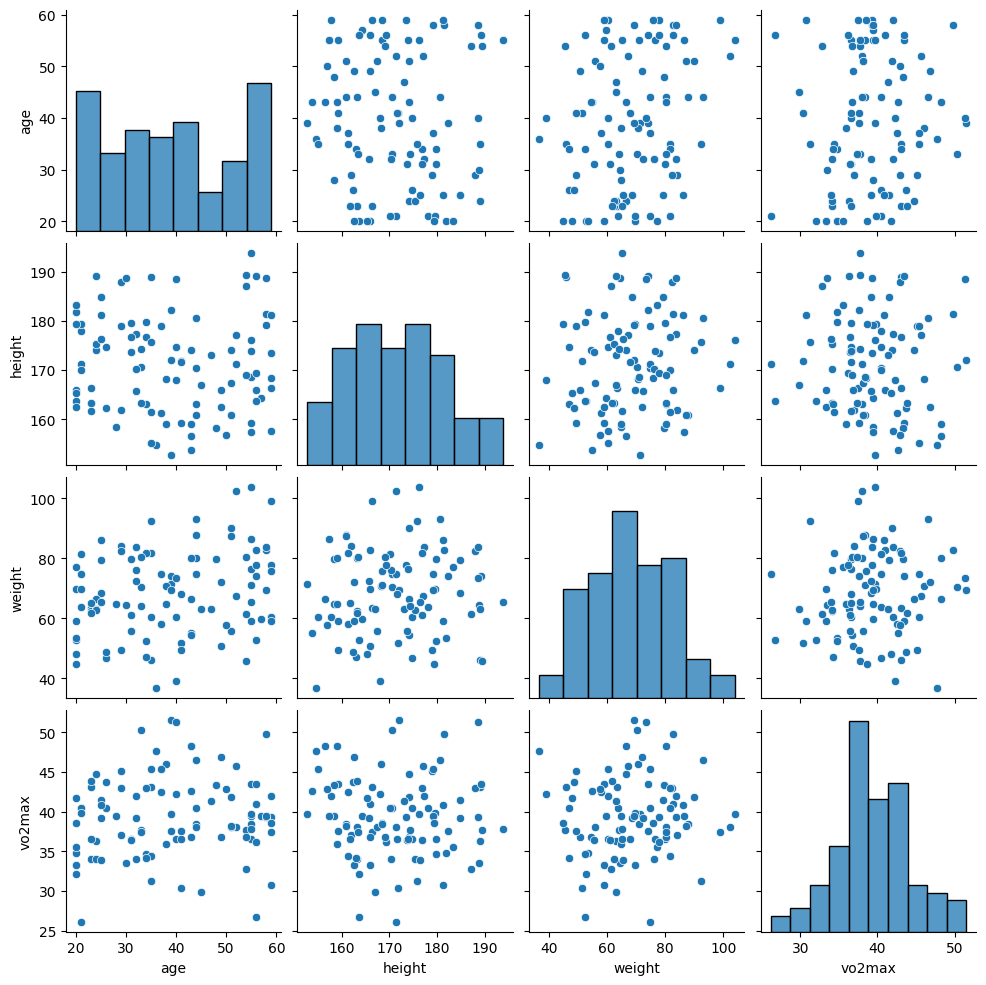

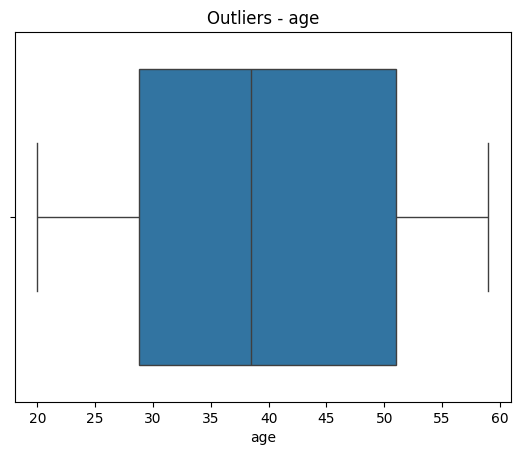

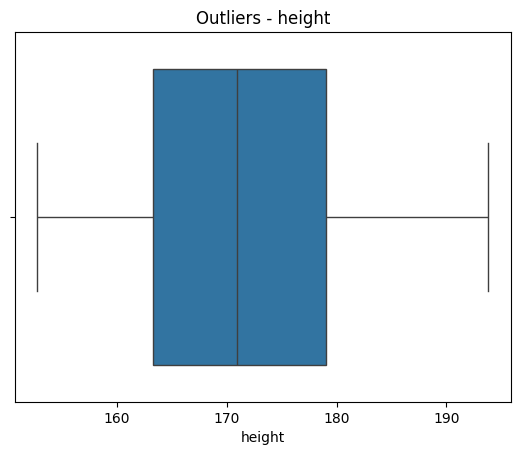

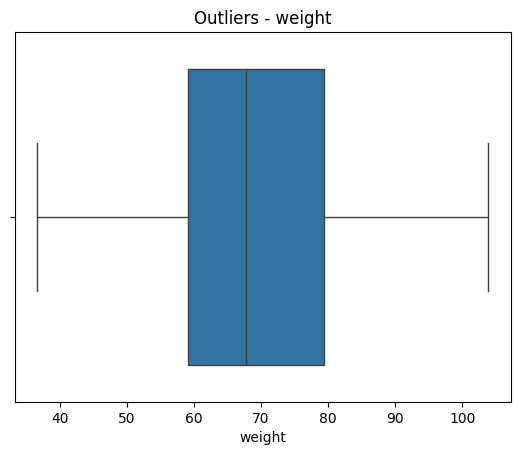

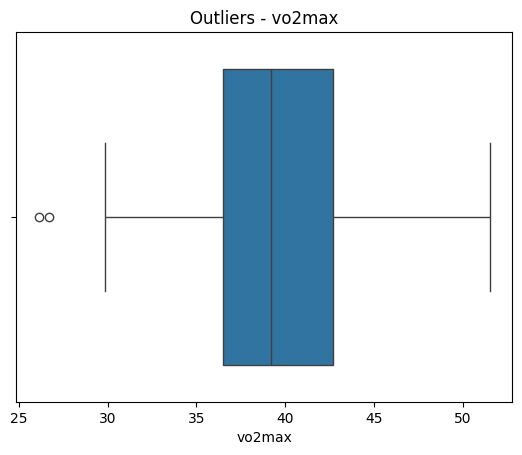

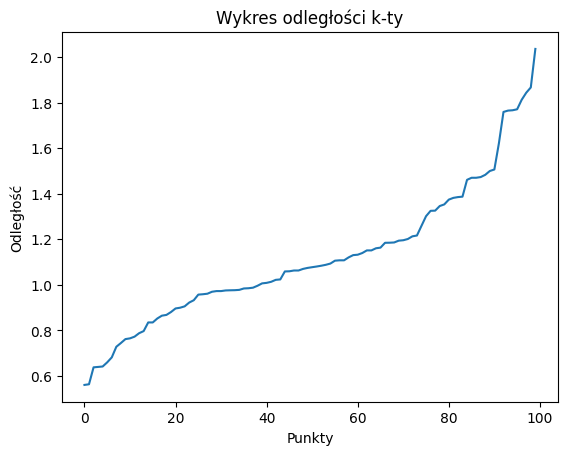

Wykryte klastry: 0
Liczba punktów szumowych: 100


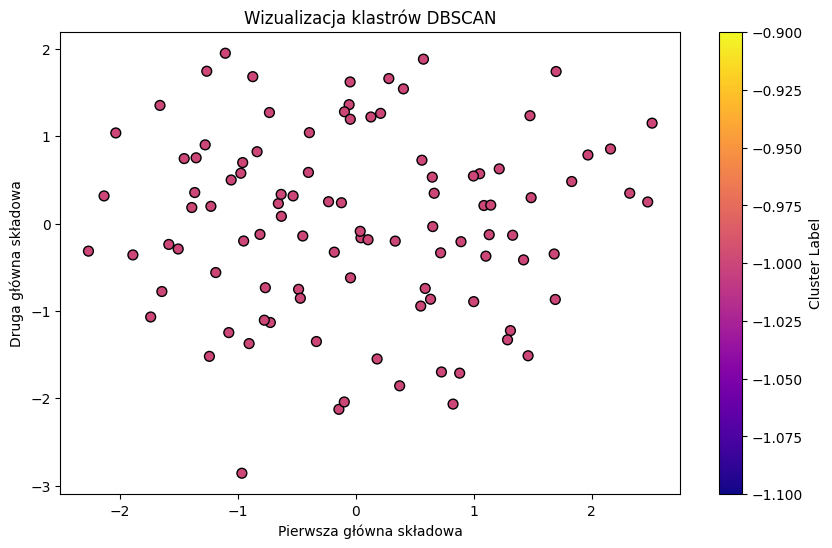

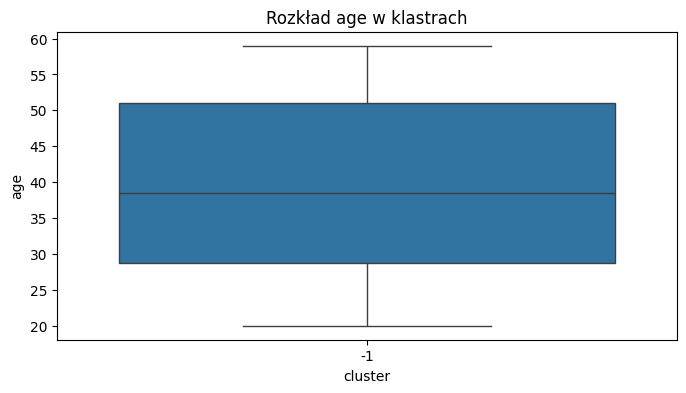

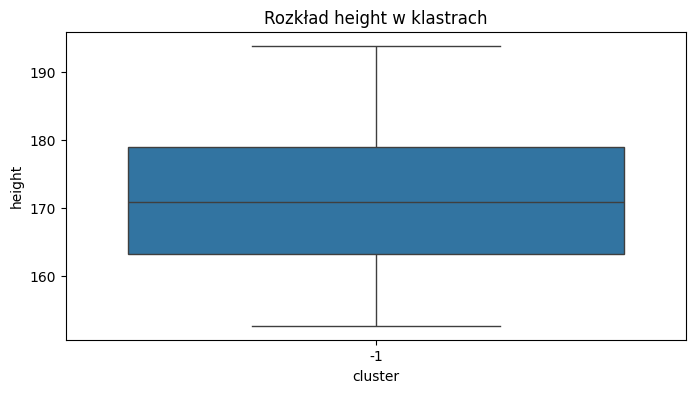

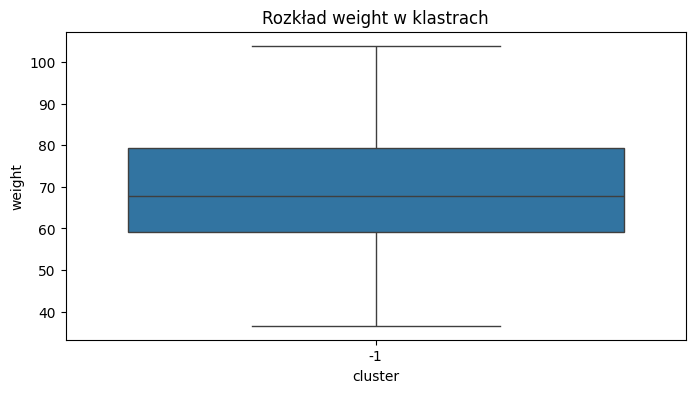

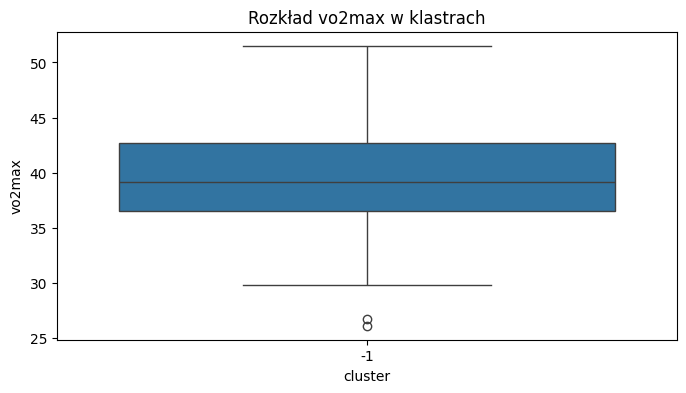

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Przygotowanie przykładowego datasetu, jeśli nie mamy własnego
# df = pd.read_csv('path_to_your_data.csv') # Użyj tego w przypadku własnych danych
np.random.seed(0)
df = pd.DataFrame({
    'age': np.random.randint(20, 60, 100),
    'height': np.random.normal(170, 10, 100),
    'weight': np.random.normal(70, 15, 100),
    'vo2max': np.random.normal(40, 5, 100)
})

# Eksploracyjna analiza danych (EDA)
print(df.describe())  # Podstawowe statystyki
print(df.info())  # Informacje o kolumnach i typach danych
sns.pairplot(df)  # Wykresy par dla szybkiego wglądu w relacje między cechami
plt.show()

# Wykrywanie i wypełnianie braków w danych
df['weight'] = df['weight'].fillna(df['weight'].mean())
df['height'] = df['height'].fillna(df['height'].mean())
df['age'] = df['age'].fillna(df['age'].median())
df['vo2max'] = df['vo2max'].fillna(df['vo2max'].median())

# Dodatkowa analiza - sprawdzenie outliers dla każdej cechy
for feature in ['age', 'height', 'weight', 'vo2max']:
    sns.boxplot(x=df[feature])
    plt.title(f'Outliers - {feature}')
    plt.show()

# Wybór cech do klasteryzacji
features = df[['age', 'height', 'weight', 'vo2max']]

# Normalizacja danych
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Analiza k-distance dla optymalizacji eps
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)
distances = np.sort(distances[:, 3], axis=0)

plt.plot(distances)
plt.title('Wykres odległości k-ty')
plt.xlabel('Punkty')
plt.ylabel('Odległość')
plt.show()

# Automatyczna optymalizacja eps i min_samples przez analizę wykresu k-distance lub silhouette
eps_value = 0.5  # Przykładowa wartość; ustal wartość po sprawdzeniu wykresu
min_samples_value = 4  # Przykładowa wartość

# Zastosowanie DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(scaled_features)
df['cluster'] = clusters

# Analiza wyników klasteryzacji
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_points = list(clusters).count(-1)
print(f'Wykryte klastry: {num_clusters}')
print(f'Liczba punktów szumowych: {noise_points}')

# Wartość silhouette (jeśli jest więcej niż 1 klaster)
if num_clusters > 1:
    silhouette_avg = silhouette_score(scaled_features, clusters)
    print(f'Silhouette Score: {silhouette_avg:.2f}')

# Wizualizacja klastrów
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='plasma', edgecolor='k', s=50)
plt.title('Wizualizacja klastrów DBSCAN')
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Analiza rozkładu cech w każdym klastrze
for col in features.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=col, data=df)
    plt.title(f'Rozkład {col} w klastrach')
    plt.show()


In [18]:
#Co chcemy zrobic 
#1.Poziomy mleczanu (la_10, la_12, la_14)
#Dlaczego? Poziomy mleczanu w różnych intensywnościach wysiłku odzwierciedlają zdolność organizmu do radzenia sobie z wysiłkiem 
#i mogą być dobrym wskaźnikiem różnic między sportowcami.
#Analiza: Sprawdzamy, jak grupują się sportowcy na podstawie ich zdolności metabolizowania mleczanu.
#2. Strefy treningowe (z2, z3, z4, z5)
#Dlaczego? Strefy tętna określają poziomy wysiłku i mogą wskazywać, jak intensywnie dany sportowiec trenuje.
#Analiza: Grupowanie sportowców na podstawie ich dominujących stref wysiłku.
#3 Relacje między age, weight, height
#Dlaczego? Parametry antropometryczne mogą odgrywać kluczową rolę w analizie grup sportowców 
#(np. w dyscyplinach takich jak biegi sprinterskie vs triathlon).
#Analiza: Grupowanie sportowców o podobnych cechach fizycznych.


Analiza pierwszej konfiguracji:
Proporcja outlierów (cluster): 11.80%

Cechy outlierów:
          vo2max       hrmax        age      weight      height
count  19.000000   19.000000  19.000000   19.000000   19.000000
mean   50.136842  178.263158  40.578947   74.121053  178.578947
std     6.090540    8.880954  10.910320   11.817152   10.351145
min    34.100000  165.000000  16.000000   53.000000  160.000000
25%    46.350000  171.500000  35.500000   66.150000  171.000000
50%    50.600000  178.000000  41.000000   72.000000  179.000000
75%    54.150000  183.000000  47.000000   79.000000  187.000000
max    62.100000  197.000000  59.000000  101.000000  193.000000

Cechy nie-outlierów:
vo2max     53.205634
hrmax     182.929577
age        34.725352
weight     75.311972
height    177.091549
dtype: float64

Analiza drugiej konfiguracji:
Proporcja outlierów (cluster_alt): 6.83%

Cechy outlierów:
          vo2max       hrmax        age      weight      height
count  11.000000   11.000000  11.000000 

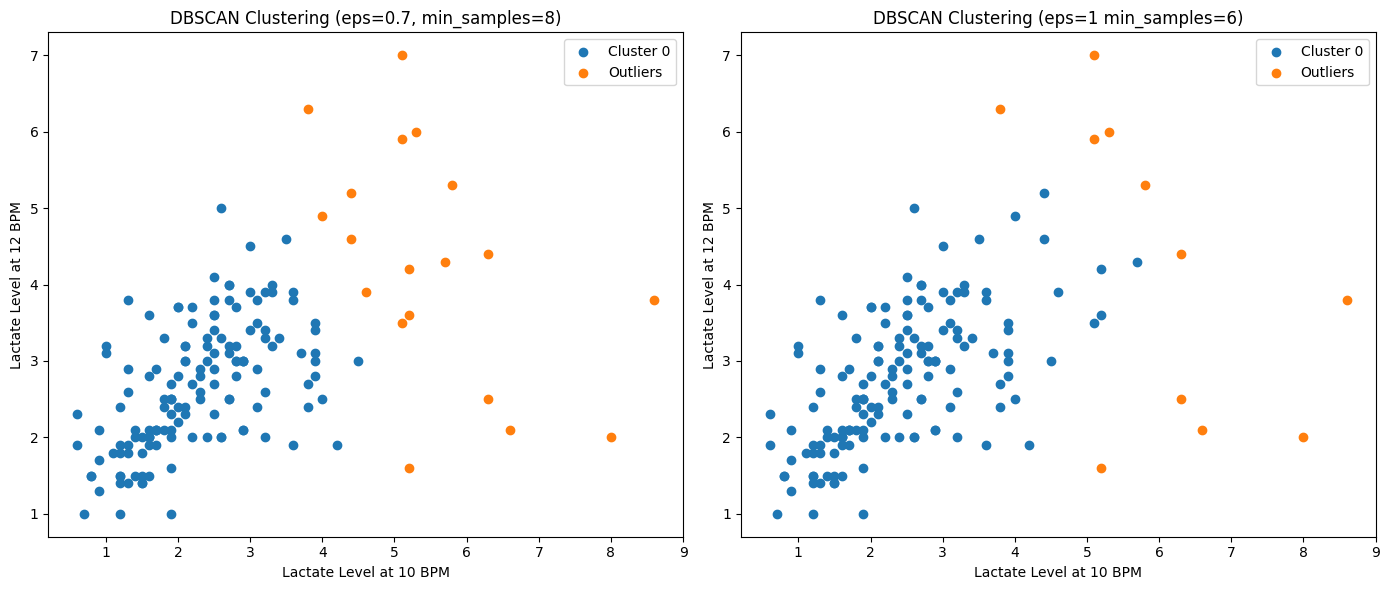


Porównanie średnich cech między klastrami dla pierwszej konfiguracji:
            vo2max       hrmax        age     weight      height
cluster                                                         
-1       50.136842  178.263158  40.578947  74.121053  178.578947
 0       53.205634  182.929577  34.725352  75.311972  177.091549

Porównanie średnich cech między klastrami dla drugiej konfiguracji:
                vo2max       hrmax        age     weight      height
cluster_alt                                                         
-1           49.618182  180.545455  41.909091  77.936364  182.818182
 0           53.080000  182.513333  34.940000  74.968667  176.860000


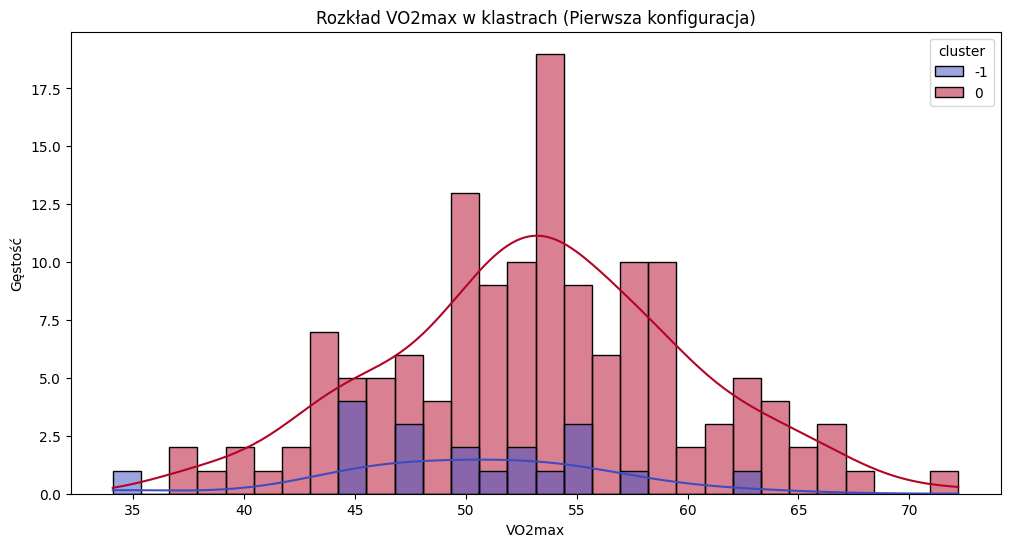

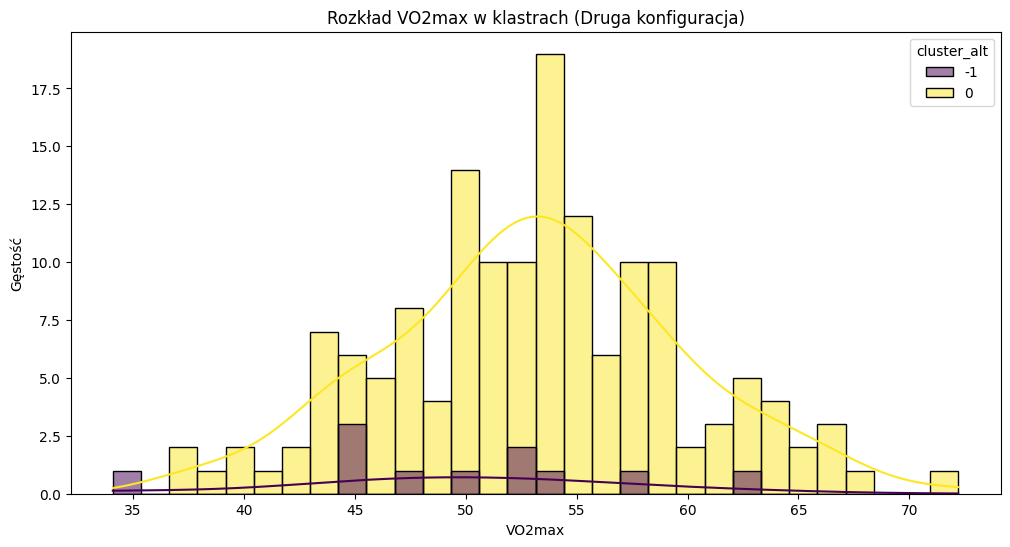

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

# Dane i parametry
# Przypuśćmy, że dane są załadowane do ramki danych "data"
data = data  # Przyjmuje że dane zostały wcześniej wczytane

# Przeprowadzanie DBSCAN dla dwóch konfiguracji
clustering1 = DBSCAN(eps=0.7, min_samples=8).fit(data[['la_10', 'la_12']])
data['cluster'] = clustering1.labels_

clustering2 = DBSCAN(eps=1.0, min_samples=6).fit(data[['la_10', 'la_12']])
data['cluster_alt'] = clustering2.labels_

# Analiza proporcji outlierów
def analyze_outliers(df, cluster_col):
    outliers = df[df[cluster_col] == -1]
    non_outliers = df[df[cluster_col] != -1]
    
    outlier_ratio = len(outliers) / len(df)
    print(f"Proporcja outlierów ({cluster_col}): {outlier_ratio:.2%}")
    print("\nCechy outlierów:")
    print(outliers[['vo2max', 'hrmax', 'age', 'weight', 'height']].describe())
    
    print("\nCechy nie-outlierów:")
    print(non_outliers[['vo2max', 'hrmax', 'age', 'weight', 'height']].mean())

print("Analiza pierwszej konfiguracji:")
analyze_outliers(data, 'cluster')
print("\nAnaliza drugiej konfiguracji:")
analyze_outliers(data, 'cluster_alt')

# Wizualizacja wyników
plt.figure(figsize=(14, 6))

# Wizualizacja pierwszej konfiguracji
plt.subplot(1, 2, 1)
for cluster in set(data['cluster']):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(cluster_data['la_10'], cluster_data['la_12'],
                label=f"Cluster {cluster}" if cluster != -1 else "Outliers")
plt.title("DBSCAN Clustering (eps=0.7, min_samples=8)")
plt.xlabel("Lactate Level at 10 BPM")
plt.ylabel("Lactate Level at 12 BPM")
plt.legend()

# Wizualizacja drugiej konfiguracji
plt.subplot(1, 2, 2)
for cluster in set(data['cluster_alt']):
    cluster_data = data[data['cluster_alt'] == cluster]
    plt.scatter(cluster_data['la_10'], cluster_data['la_12'],
                label=f"Cluster {cluster}" if cluster != -1 else "Outliers")
plt.title("DBSCAN Clustering (eps=1 min_samples=6)")
plt.xlabel("Lactate Level at 10 BPM")
plt.ylabel("Lactate Level at 12 BPM")
plt.legend()

plt.tight_layout()
plt.show()

# Porównanie średnich cech między klastrami
print("\nPorównanie średnich cech między klastrami dla pierwszej konfiguracji:")
print(data.groupby('cluster')[['vo2max', 'hrmax', 'age', 'weight', 'height']].mean())

print("\nPorównanie średnich cech między klastrami dla drugiej konfiguracji:")
print(data.groupby('cluster_alt')[['vo2max', 'hrmax', 'age', 'weight', 'height']].mean())

# Wizualizacja histogramów dla VO2max w klastrach
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='vo2max', hue='cluster', kde=True, palette="coolwarm", bins=30)
plt.title("Rozkład VO2max w klastrach (Pierwsza konfiguracja)")
plt.xlabel("VO2max")
plt.ylabel("Gęstość")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='vo2max', hue='cluster_alt', kde=True, palette="viridis", bins=30)
plt.title("Rozkład VO2max w klastrach (Druga konfiguracja)")
plt.xlabel("VO2max")
plt.ylabel("Gęstość")
plt.show()

In [ ]:
# Cel Kodu:
# Kod implementuje algorytm DBSCAN (Density-Based Spatial Clustering of Applications with Noise) do grupowania danych, 
# a konkretnie poziomu mleczanu (lactate level) mierzonego przy 10 i 12 uderzeniach serca na minutę (BPM). 
# Dodatkowo, analizowane są cechy takie jak VO2max, tętno maksymalne (hrmax), wiek, waga i wzrost dla zidentyfikowanych 
# klastrów i outlierów.

# Kluczowe Parametry DBSCAN:
# eps (epsilon): Określa promień otoczenia wokół punktu. Punkty w odległości mniejszej lub równej eps są uważane za sąsiadów. 
# Zwiększenie eps powoduje, że więcej punktów jest grupowanych razem, co może skutkować mniejszą liczbą klastrów 
# (w tym potencjalnie 1 klastrem zawierającym prawie wszystkie punkty) i mniejszą liczbą outlierów. 
# Zmniejszenie eps prowadzi do tworzenia mniejszych, bardziej zwartych klastrów i potencjalnie większej liczby outlierów.
# min_samples: Określa minimalną liczbę punktów (w tym punkt sam w sobie) w otoczeniu o promieniu eps, 
# aby punkt został uznany za punkt rdzenny (core point). Zwiększenie min_samples powoduje, że trudniej jest punktowi 
# stać się punktem rdzennym, co może prowadzić do większej liczby outlierów i potencjalnie rozpadu istniejących klastrów. 
# Zmniejszenie min_samples ułatwia punktom stanie się punktami rdzeniami, co może skutkować łączeniem mniejszych klastrów 
# w większe i zmniejszeniem liczby outlierów.

# Analiza Kodu Krok po Kroku:
# 1. Import Bibliotek: Importowane są niezbędne biblioteki: numpy, pandas, matplotlib, seaborn i sklearn.cluster.DBSCAN.
# 2. Dane: Zakłada się, że dane są załadowane do ramki danych "data". Kod operuje na kolumnach la_10 (poziom mleczanu przy 10 BPM) 
#    i la_12 (poziom mleczanu przy 12 BPM).
# 3. Dwie Konfiguracje DBSCAN: Przeprowadzane jest grupowanie DBSCAN dla dwóch zestawów parametrów:
#    clustering1 = DBSCAN(eps=0.7, min_samples=8)
#    clustering2 = DBSCAN(eps=1.0, min_samples=6) Widać, że w drugiej konfiguracji zwiększono eps i zmniejszono min_samples.
# 4. Analiza Outlierów: Funkcja analyze_outliers oblicza proporcję outlierów (punktów oznaczonych jako -1) i opisuje ich cechy 
#    (średnie dla vo2max, hrmax, age, weight, height), a także średnie cechy punktów nie będących outlierami.
# 5. Wizualizacja: Wyniki grupowania są wizualizowane na dwóch wykresach punktowych (scatter plots), po jednym dla każdej konfiguracji. 
#    Outliery są oznaczane oddzielnym kolorem.
# 6. Porównanie Średnich Cech: Obliczane i wyświetlane są średnie wartości cech (vo2max, hrmax, age, weight, height) dla każdego klastra 
#    (w tym outlierów) oddzielnie dla obu konfiguracji.
# 7. Histogramy VO2max: Tworzone są histogramy rozkładu VO2max w poszczególnych klastrach, co pozwala na wizualne porównanie rozkładów 
#    tej cechy między klastrami.

# Interpretacja Wyników i Wpływ Parametrów:
# 1. Wizualizacja (Wykresy Punktowe): Wykresy pokazują, jak różne wartości eps i min_samples wpływają na kształt i liczbę klastrów. 
#    Zwiększenie eps (z 0.7 do 1.0) i zmniejszenie min_samples (z 8 do 6) spowodowało, że punkty, które wcześniej były klasyfikowane 
#    jako outliery, zostały włączone do klastra. To jest zgodne z oczekiwaniami, ponieważ zwiększony promień eps "zbiera" więcej punktów, 
#    a mniejszy min_samples ułatwia tworzenie gęstych obszarów.
# 2. Analiza Outlierów (Proporcje i Opisy): Analiza outlierów dostarcza informacji o tym, ile punktów zostało uznanych za outliery w każdej 
#    konfiguracji. Opis statystyczny cech outlierów i punktów nie będących outlierami pozwala na identyfikację potencjalnych różnic między 
#    tymi grupami. Na przykład, można zauważyć, czy outliery charakteryzują się niższym/wyższym VO2max, innym wiekiem, wagą lub wzrostem.
# 3. Porównanie Średnich Cech: Tabele ze średnimi cechami dla klastrów pozwalają na porównanie profili poszczególnych grup. Można zaobserwować, 
#    czy istnieją istotne różnice w średnich wartościach vo2max, hrmax itp. między klastrami.
# 4. Histogramy VO2max: Histogramy wizualizują rozkład VO2max w klastrach, co ułatwia identyfikację różnic w rozkładach tej cechy między grupami.

# Podsumowanie:
# Kod ten demonstruje użycie algorytmu DBSCAN i pokazuje, jak parametry eps i min_samples wpływają na wyniki grupowania. 
# Analiza outlierów i porównanie średnich cech pozwalają na lepsze zrozumienie struktury danych i identyfikację potencjalnych różnic 
# między grupami. Ważne jest, aby eksperymentować z różnymi wartościami eps i min_samples, aby znaleźć optymalne parametry dla danego zbioru danych. 
# Dodatkowo, analiza kontekstu danych (np. co oznaczają wartości mleczanu, VO2max itp.) jest kluczowa dla pełnej interpretacji wyników.
#Zwiększenie wartości eps prowadzi do bardziej "rozciągniętych" klastrów, łącząc więcej punktów w jeden klaster i zmniejszając liczbę outlierów. 
#Zmniejszenie min_samples ułatwia punktom stawanie się punktami rdzeniowymi, co może skutkować połączeniem mniejszych klastrów w większe, a także zmniejszeniem liczby outlierów. W efekcie, oba te parametry mają wpływ na gęstość klastrów i klasyfikację punktów jako outliery lub członków klastra.

Liczba klastrów (bez wartości odstających): 3
Liczba wartości odstających: 141
Średni współczynnik Silhouette: 0.53

Statystyki klastrów:
           age                                                      height  \
         count       mean        std   min   25%   50%    75%   max  count   
cluster                                                                      
-1       141.0  34.787234  10.942583  16.0  27.0  34.0  42.00  62.0  141.0   
 0        10.0  34.600000   3.098387  29.0  33.0  34.5  36.75  40.0   10.0   
 1         5.0  47.200000   1.483240  45.0  47.0  47.0  48.00  49.0    5.0   
 2         5.0  43.000000   3.000000  40.0  40.0  43.0  46.00  46.0    5.0   

                     ...  vo2max        hrmax                                \
               mean  ...     75%   max  count        mean        std    min   
cluster              ...                                                      
-1       177.617021  ...  56.300  72.2  141.0  182.432624  11.234071  148.0   

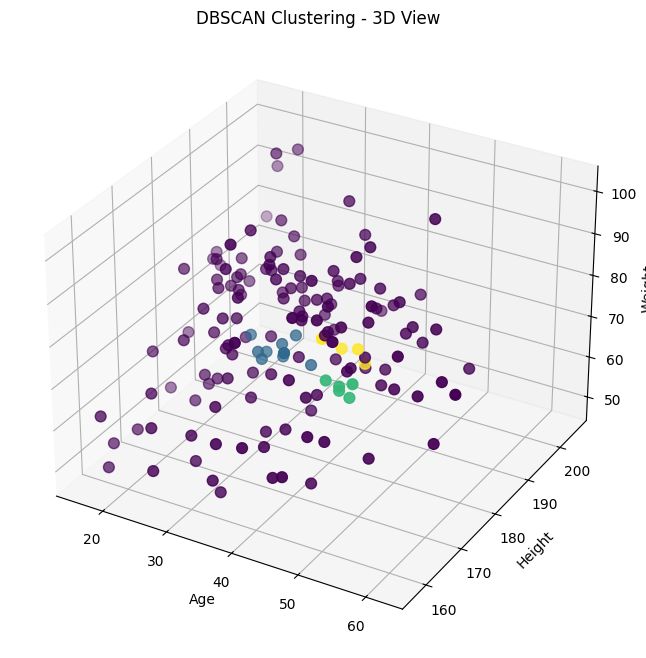

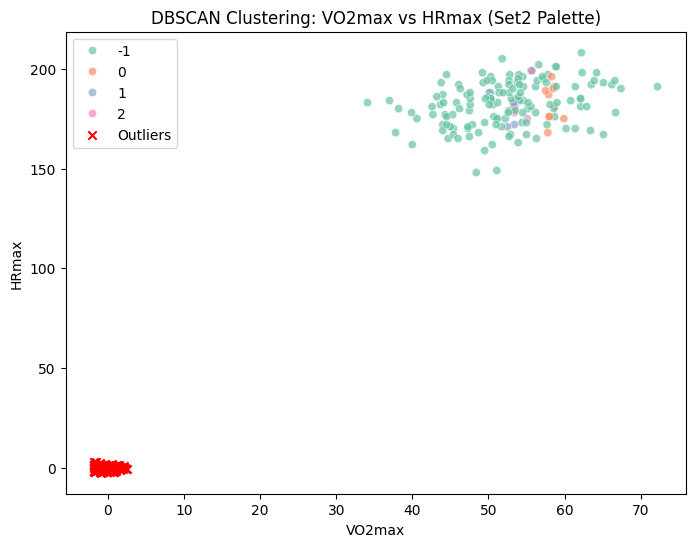

eps: 0.3, min_samples: 3 -> Brak klastrów (lub tylko wartości odstające)
eps: 0.3, min_samples: 5 -> Brak klastrów (lub tylko wartości odstające)
eps: 0.3, min_samples: 7 -> Brak klastrów (lub tylko wartości odstające)
eps: 0.5, min_samples: 3 -> Średni współczynnik Silhouette: 0.39
eps: 0.5, min_samples: 5 -> Średni współczynnik Silhouette: 0.53
eps: 0.5, min_samples: 7 -> Brak klastrów (lub tylko wartości odstające)
eps: 0.7, min_samples: 3 -> Średni współczynnik Silhouette: 0.13
eps: 0.7, min_samples: 5 -> Średni współczynnik Silhouette: 0.20
eps: 0.7, min_samples: 7 -> Średni współczynnik Silhouette: 0.36
Procent wartości odstających: 87.58%


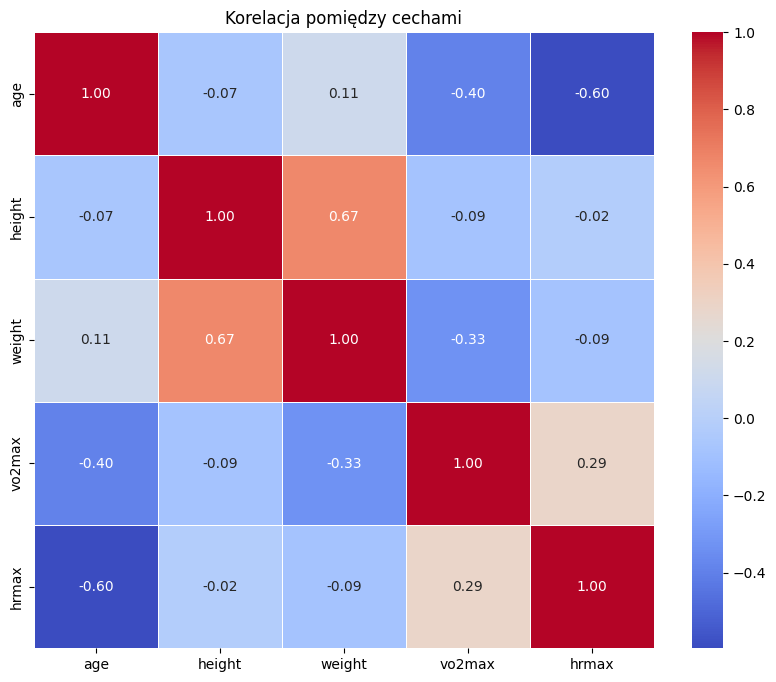


Podsumowanie dla klastra 0:
             age      height     weight    vo2max       hrmax
count  10.000000   10.000000  10.000000  10.00000   10.000000
mean   34.600000  175.500000  72.650000  58.32000  182.900000
std     3.098387    2.173067   2.186448   0.67297    8.974656
min    29.000000  173.000000  69.000000  57.50000  168.000000
25%    33.000000  173.250000  71.250000  57.92500  176.000000
50%    34.500000  175.500000  72.750000  58.15000  184.000000
75%    36.750000  177.750000  74.750000  58.57500  189.750000
max    40.000000  178.000000  75.000000  59.90000  196.000000

Podsumowanie dla klastra 1:
            age      height     weight     vo2max       hrmax
count   5.00000    5.000000   5.000000   5.000000    5.000000
mean   47.20000  170.200000  73.600000  52.520000  179.400000
std     1.48324    0.447214   1.710263   1.400714    7.503333
min    45.00000  170.000000  71.000000  50.100000  171.000000
25%    47.00000  170.000000  73.000000  52.500000  172.000000
50%    47.00

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import silhouette_score
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Wczytanie danych i skalowanie
file_path = 'sport.csv'
df = pd.read_csv(file_path)  # Wczytanie danych z pliku CSV
X = df[['age', 'height', 'weight', 'vo2max']]  # Wybór kolumn do analizy
X_scaled = StandardScaler().fit_transform(X)  # Skalowanie danych (standardyzacja)

# Klasteryzacja DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ustawienie parametrów DBSCAN: eps i min_samples
clusters = dbscan.fit_predict(X_scaled)  # Klasteryzacja za pomocą DBSCAN

# Dodanie etykiet klastrów do danych
df['cluster'] = clusters  # Dodanie etykiet klastrów do DataFrame

# Analiza wyników
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Liczenie liczby klastrów (ignorując wartości odstające)
num_outliers = sum(clusters == -1)  # Liczenie liczby punktów odstających (-1)
print(f"Liczba klastrów (bez wartości odstających): {num_clusters}")
print(f"Liczba wartości odstających: {num_outliers}")

# Współczynnik Silhouette
silhouette_avg = silhouette_score(X_scaled[clusters != -1], clusters[clusters != -1])  # Obliczanie średniego współczynnika Silhouette dla punktów, które nie są odstające
print(f'Średni współczynnik Silhouette: {silhouette_avg:.2f}')

# Analiza statystyczna klastrów
print("\nStatystyki klastrów:")
print(df.groupby('cluster')[['age', 'height', 'weight', 'vo2max', 'hrmax']].describe())  # Podstawowe statystyki dla cech w ramach każdego klastra

# Wizualizacja 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Tworzenie wykresu 3D
ax.scatter(df['age'], df['height'], df['weight'], c=df['cluster'], cmap='viridis', s=60)  # Wizualizacja punktów z etykietami klastrów
ax.set_xlabel('Age')  # Etykieta osi X
ax.set_ylabel('Height')  # Etykieta osi Y
ax.set_zlabel('Weight')  # Etykieta osi Z
plt.title("DBSCAN Clustering - 3D View")  # Tytuł wykresu
plt.show()  # Wyświetlenie wykresu

# Wizualizacja wyników klasteryzacji z różnymi paletami
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['vo2max'], y=df['hrmax'], hue=clusters, palette='Set2', legend='full', alpha=0.7)  # Wykres 2D z paletą Set2
plt.scatter(X_scaled[clusters == -1, 0], X_scaled[clusters == -1, 1], color='red', label='Outliers', marker='x')  # Zaznaczenie punktów odstających na czerwono
plt.title('DBSCAN Clustering: VO2max vs HRmax (Set2 Palette)')  # Tytuł wykresu
plt.xlabel('VO2max')  # Etykieta osi X
plt.ylabel('HRmax')  # Etykieta osi Y
plt.legend()  # Dodanie legendy
plt.show()  # Wyświetlenie wykresu


# Funkcja do obliczania średniego współczynnika Silhouette dla różnych wartości eps i min_samples
def evaluate_dbscan(X_scaled, eps_values, min_samples_values):
    for eps in eps_values:  # Testowanie różnych wartości eps
        for min_samples in min_samples_values:  # Testowanie różnych wartości min_samples
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)  # Inicjalizacja DBSCAN z parametrami
            clusters = dbscan.fit_predict(X_scaled)  # Klasteryzacja z danymi
            # Sprawdzamy, czy liczba klastrów jest większa niż 1 (bez wartości odstających)
            unique_clusters = set(clusters) - {-1}  # Usuwamy wartość odstającą (-1)
            if len(unique_clusters) > 1:  # Aby uniknąć błędów przy braku klastrów
                silhouette_avg = silhouette_score(X_scaled[clusters != -1], clusters[clusters != -1])  # Obliczanie współczynnika Silhouette
                print(f"eps: {eps}, min_samples: {min_samples} -> Średni współczynnik Silhouette: {silhouette_avg:.2f}")
            else:
                print(f"eps: {eps}, min_samples: {min_samples} -> Brak klastrów (lub tylko wartości odstające)")  # Brak klastrów lub tylko wartości odstające

# Test różnych wartości eps i min_samples
eps_values = [0.3, 0.5, 0.7]  # Definicja testowanych wartości eps
min_samples_values = [3, 5, 7]  # Definicja testowanych wartości min_samples
evaluate_dbscan(X_scaled, eps_values, min_samples_values)  # Uruchomienie funkcji testującej różne kombinacje parametrów

# Procentowy udział wartości odstających
outliers_percentage = num_outliers / len(df) * 100  # Obliczanie procentowego udziału punktów odstających
print(f"Procent wartości odstających: {outliers_percentage:.2f}%")  # Wypisanie procentu wartości odstających

# Mapa ciepła dla korelacji
plt.figure(figsize=(10, 8))
corr_matrix = df[['age', 'height', 'weight', 'vo2max', 'hrmax']].corr()  # Obliczanie macierzy korelacji
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)  # Wizualizacja mapy ciepła z annotacją
plt.title('Korelacja pomiędzy cechami')  # Tytuł wykresu
plt.show()  # Wyświetlenie wykresu

# Podsumowanie dla każdego klastra
for cluster_num in range(num_clusters):  # Iteracja po klastrach
    cluster_data = df[df['cluster'] == cluster_num]  # Wybór danych dla danego klastra
    print(f"\nPodsumowanie dla klastra {cluster_num}:")
    print(cluster_data[['age', 'height', 'weight', 'vo2max', 'hrmax']].describe())  # Podstawowe statystyki dla cech w klastra


#Klasteryzacja DBSCAN: DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
#to algorytm klasteryzacji, który identyfikuje gęste obszary w przestrzeni danych. Parametr 
#eps=0.5 określa maksymalną odległość, jaką mogą dzielić się punkty w obrębie tego samego klastra, 
#a min_samples=5 określa minimalną liczbę punktów w sąsiedztwie, które muszą istnieć, aby uznać je za część klastra. 
#Funkcja fit_predict() zwraca etykiety klastrów.

##Liczba punktów odstających jest obliczana przez zliczanie wystąpień -1 w etykietach.
#Następnie obie wartości są wypisywane na ekranie.


#Obliczanie współczynnika Silhouette: 
#Współczynnik Silhouette mierzy jakość klasteryzacji, 
#uwzględniając zarówno spójność klastrów, jak i ich separację.
#Funkcja silhouette_score oblicza średni współczynnik dla punktów, 
#które nie są wartościami odstającymi (czyli mają etykiety różne od -1).


#Statystyki klastrów: W tej sekcji obliczane są podstawowe statystyki (takie jak średnia,
#odchylenie standardowe, min, max) dla cech age, height, weight, vo2max, hrmax, pogrupowanych według etykiet klastrów. 
#Dzięki temu można lepiej zrozumieć cechy charakterystyczne dla poszczególnych klastrów.


#Wizualizacja 3D: Tworzenie wykresu 3D przedstawiającego dane z cechami age, height i weight. 
#Kolory punktów są zgodne z etykietami klastrów. Tego typu wizualizacja pomaga zobaczyć, 
#jak dane są rozmieszczone w przestrzeni trzech wymiarów i jak dobrze algorytm DBSCAN rozdziela je na klastry.


#Wizualizacja 2D: Tutaj tworzony jest wykres 2D przedstawiający zależności między vo2max a hrmax. 
#Punkty są kolorowane według etykiet klastrów, a punkty odstające są zaznaczone na czerwono. 
#To umożliwia ocenę, jak dobrze algorytm DBSCAN identyfikuje różne grupy i separuje punkty odstające.

#Funkcja do oceny DBSCAN: Funkcja testuje różne kombinacje parametrów eps i min_samples w celu znalezienia 
#najlepszego ustawienia dla algorytmu DBSCAN. Dla każdej kombinacji obliczany jest współczynnik Silhouette, jeśli liczba klastrów jest większa niż 1.

#Mapa ciepła dla korelacji: Tworzona jest mapa ciepła, która pokazuje korelacje między cechami 
#(age, height, weight, vo2max, hrmax). Pozwala to na ocenę zależności między różnymi zmiennymi.
